# Setup Preprocessing Libraries and Data Loading

In [48]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [49]:
os.path.join('D:\ML\ML Projects\jigsaw-toxic-comment-classification-challenge','train.csv','train.csv')

'D:\\ML\\ML Projects\\jigsaw-toxic-comment-classification-challenge\\train.csv\\train.csv'

In [50]:
df=pd.read_csv(os.path.join('D:/ML/ML Projects/jigsaw-toxic-comment-classification-challenge','D:/ML/ML Projects/jigsaw-toxic-comment-classification-challenge/train.csv','D:/ML/ML Projects/jigsaw-toxic-comment-classification-challenge/train.csv'))

In [51]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [52]:
df.iloc[3]['comment_text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [53]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

# Preparing Comment or TOKENISATION

In [54]:
from tensorflow.keras.layers import TextVectorization

In [55]:
X=df['comment_text']
y=df[df.columns[2:]].values

In [56]:
MAX_FEATURES=200000 #number of words in the vocablory

In [57]:
vectorizer=TextVectorization(max_tokens=MAX_FEATURES,output_sequence_length=1800,output_mode='int')

In [58]:
vectorizer.adapt(X.values)

In [59]:
vectorizer('Hello world,life is great')[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([286,   1,   9, 275,   0], dtype=int64)>

In [60]:
vectorized_text=vectorizer(X.values)

In [61]:
len(X)

159571

In [62]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [63]:
#MCSHBAP -map,cache,shuffle,batch,prefetch  from_tensor_slices, list_dir

dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset=dataset.cache()
dataset=dataset.shuffle(160000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)  #helps prevents bottlenecks

In [ ]:
batch_X,batch_y=dataset.as_numpy_iterator().next()


In [65]:
int(len(dataset)*.7)

6981

In [66]:
train=dataset.take(int(len(dataset)*.7))
val=dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*.2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [67]:
train.as_numpy_iterator().next()

(array([[   8, 1617,    2, ...,    0,    0,    0],
        [   8,   69,   53, ...,    0,    0,    0],
        [  54,    9,    6, ...,    0,    0,    0],
        ...,
        [2587,    9,    6, ...,    0,    0,    0],
        [ 650,    2,  234, ...,    0,    0,    0],
        [ 286,    1,   14, ...,    0,    0,    0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

# Build the DEEP Neural Network

# Creating a Sequential Model

In [68]:
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,Dense,Embedding # Different layers used in model
from tensorflow.keras.models import Sequential

In [69]:
model=Sequential()   #Our Model

In [70]:
#craeting the embedding layer
model.add(Embedding(MAX_FEATURES+1,32))
#creating the LSTM layers
# 'tanh' is used because of GPU requirement by tensorflow
model.add(Bidirectional(LSTM(32,activation='tanh')))
#creating the Dense layer
#used as feature extractor for fully connected layers
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
#Final Layer
#it is used to convert the multiple different layers value to the final out values
# here there are 6 column outcomes like toxicity,mild toxicity etc..
#sigmoid converts the values between 0 and 1
model.add(Dense(6,activation='sigmoid'))

In [71]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [73]:
history=model.fit(train,epochs=3,validation_data=val)

Epoch 1/3
6981/6981 [==============================] - 4176s 598ms/step - loss: 0.0619 - val_loss: 0.0483
Epoch 2/3
6981/6981 [==============================] - 4271s 612ms/step - loss: 0.0446 - val_loss: 0.0397
Epoch 3/3
6981/6981 [==============================] - 4087s 585ms/step - loss: 0.0398 - val_loss: 0.0342


In [74]:
history.history

{'loss': [0.061872098594903946, 0.04463312774896622, 0.03980354964733124],
 'val_loss': [0.04825005307793617, 0.0396818146109581, 0.034192830324172974]}

In [75]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

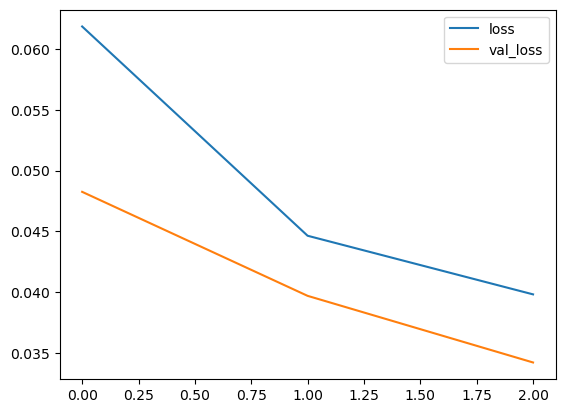

In [76]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [77]:
batch=test.as_numpy_iterator().next()

In [78]:
input_text=vectorizer("I am going to blast u with a bomb")

In [79]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [80]:
batch=test.as_numpy_iterator().next()

In [81]:
batch_X,batch_y=test.as_numpy_iterator().next()

In [82]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 1s 897ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [83]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [84]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 68ms/step


array([[1.8466394e-02, 1.5185812e-05, 1.2945253e-03, 5.2540551e-04,
        2.7812622e-03, 3.4318827e-04]], dtype=float32)

In [74]:
#  res=model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 68ms/step


In [85]:
res=model.predict(batch_X)

1/1 [==============================] - 0s 99ms/step


(16, 6)

# Evaluate Model

In [86]:
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy

In [87]:
pre=Precision()
re=Recall()
acc=CategoricalAccuracy()

In [88]:
for batch in test.as_numpy_iterator():
    #unpack the batch
    X_true,y_true=batch
    #making a prediction
    yhat=model.predict(X_true)
    
    #Flatten the predictions
    y_true=y_true.flatten()
    yhat=yhat.flatten()
    
    pre.update_state(y_true,yhat)
    re.update_state(y_true,yhat)
    acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 100ms/step


In [89]:
print(f'Precision: { pre.result().numpy()},Recall: { re.result().numpy()},Accuracy: { acc.result().numpy()}a')

Precision: 0.851165771484375,Recall: 0.7629544734954834,Accuracy: 0.49448344111442566a


# Test and Build the gradio App

In [90]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import Sequential
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [91]:
#save model
model.save('Comment_Toxicity_with_epoch_3.h5') 

In [22]:
#import model
model=tf.keras.models.load_model('C:/Users/Tusha/ML Projects/Comment_toxicity.h5')

# Testing

In [92]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [93]:
input_str=vectorizer("hey nigga i fucking hate you!")
res=model.predict(np.expand_dims(input_str,0))
res

1/1 [==============================] - 0s 64ms/step


array([[0.9994734 , 0.43153623, 0.96383435, 0.11705021, 0.93353474,
        0.33313805]], dtype=float32)

In [94]:
def score_comment(comment):
    vectorized_comment=vectorizer([comment])
    results=model.predict(vectorized_comment)
    
    text=''
    for idx,col in enumerate(df.columns[2:]):
        text+='{}:{}\n'.format(col,results[0][idx]>0.5)
    
    return text

In [95]:
interface=gr.Interface(fn=score_comment,inputs=gr.inputs.Textbox(lines=2,placeholder='Comment to score'),
                      outputs='text',
                      description="Comment and know its toxicity...\n Created by Tushar Gahtori")

C:\Users\Tusha\AppData\Roaming\Python\Python39\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\Tusha\AppData\Roaming\Python\Python39\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Tusha\AppData\Roaming\Python\Python39\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [96]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7867
Running on public URL: https://009acefa-26be-4486.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 70ms/step
